<a href="https://colab.research.google.com/github/vicmcl/ml-laptime/blob/main/ml_laptime/notebook/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Import**

In [68]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import seaborn as sns
import xgboost as xgb

from pathlib import Path
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import (
    TimeSeriesSplit, train_test_split, GridSearchCV
)

In [2]:
# Mount Drive
from google.colab import drive

drive.flush_and_unmount()
drive.mount('/content/drive')
DRIVE_PATH = Path("/content/drive/MyDrive/")
ML_PATH = DRIVE_PATH / "Projects" / "laptime-simulation"

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [3]:
data_path = glob.glob(str(ML_PATH / "races_*.pkl"))

In [4]:
pip install -q fastf1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.3/148.3 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 3.3 MB/s eta 0:00:00


In [5]:
data_path

['/content/drive/MyDrive/Projects/laptime-simulation/races_2019.pkl',
 '/content/drive/MyDrive/Projects/laptime-simulation/races_2020.pkl',
 '/content/drive/MyDrive/Projects/laptime-simulation/races_2021.pkl']

In [6]:
data = {}

for path in data_path:
    with open(path, "rb") as f:
        data[int(path.split(".")[0][-4:])] = pickle.load(f)

## **Feature engineering**

In [7]:
columns_laps = [
    'Time', 'LapNumber', 'Stint', 'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST',
    'Compound', 'TyreLife', 'LapTime', 'PitOutTime', 'PitInTime'
]

columns_telemetry = ['SessionTime', 'Throttle', 'Brake']

columns_weather = ['Time', 'TrackTemp']

compound_map = {
    'SOFT': 1.0,
    'MEDIUM': 2.0,
    'HARD': 3.0
}

In [58]:
def process_track_status(gp, year):
    track_status = data[year][gp]['status'].copy()
    track_status['Incident'] = track_status['Status'].map(lambda s: False if s == '1' else True)
    mask = track_status['Incident'] & track_status['Incident'].shift(1)
    track_status = track_status[~mask][['Time', 'Incident']]
    return track_status


def laps_with_incident(laps, incident_times, allclear_times):
    laps_to_remove = []
    # Loop over every incident
    for start_incident, end_incident in zip(incident_times, allclear_times):
        i = 0
        # Find the first impacted lap
        while pd.Timedelta(laps['Time'].iloc[i]) < start_incident:
            i += 1
        laps_to_remove.append(laps['Time'].iloc[i])

        # If the incident is not over by the end of the lap, remove the next lap
        # and repeat until the incident is over
        while pd.Timedelta(laps['Time'].iloc[i]) < end_incident:
            laps_to_remove.append(laps['Time'].iloc[i + 1])
            i += 1
    return laps_to_remove


def remove_incidents(laps, track_status):
    laps_data = laps.copy()
    incident_times = track_status[track_status['Incident'] == True]['Time'].tolist()
    allclear_times = track_status[track_status['Incident'] == False]['Time'].iloc[1:].tolist()
    laps_to_remove = laps_with_incident(laps_data, incident_times, allclear_times)
    laps_data = laps_data[~laps_data["Time"].isin(laps_to_remove)]
    return laps_data


def remove_pitstops(laps):
    laps_data = laps.copy()
    mask = pd.isnull(laps_data['PitOutTime']) & pd.isnull(laps_data['PitInTime'])
    laps_data = laps_data[mask]
    laps_data = laps_data.drop(['PitOutTime', 'PitInTime'], axis=1)
    return laps_data


def process_lap_data(gp, year):
    laps_data = data[year][gp]['laps'][columns_laps].copy()
    laps_data['Season'] = year
    laps_data = laps_data.reset_index().drop('index', axis=1)
    laps_data['Compound'] = laps_data['Compound'].map(lambda x: compound_map.get(x, 0.0))
    laps_data = remove_pitstops(laps_data)
    track_status = process_track_status(gp, year)
    laps_data = remove_incidents(laps_data, track_status)
    return laps_data


def map_drs(drs):
    return True if drs >= 10 else False


def process_telemetry_data(gp, year, laps):
    telemetry_data = data[year][gp]['telemetry'][columns_telemetry].copy()
    telemetry_with_laps = pd.merge_asof(
        telemetry_data,
        laps[['Time', 'LapNumber']],
        left_on='SessionTime',
        right_on='Time',
        direction='forward'
    ).drop('Time', axis=1)
    #telemetry_with_laps.loc[:, 'DRS'] = telemetry_with_laps['DRS'].map(map_drs)
    telemetry_avg = telemetry_with_laps.groupby('LapNumber').mean()
    return telemetry_avg


def process_weather_data(gp, year):
    weather_data = data[year][gp]['weather'][columns_weather].copy()
    return weather_data


def merge_data(laps, weather, telemetry):
    merged_data = pd.merge_asof(laps, weather, on='Time', direction='nearest').set_index('LapNumber').drop('Time', axis=1)
    merged_data = pd.concat([merged_data, telemetry], axis=1).reset_index()
    merged_data = merged_data.drop('SessionTime', axis=1)
    merged_data.loc[:, 'LapTime'] = merged_data['LapTime'].map(lambda x: x.total_seconds())
    return merged_data


def preprocess_data(gp, year):
    laps = process_lap_data(gp, year)
    weather = process_weather_data(gp, year)
    telemetry = process_telemetry_data(gp, year, laps)
    merged_data = merge_data(laps, weather, telemetry)
    return merged_data


def select_speed_trap(data):
    corr = data[['LapTime', 'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST']].corr()
    speed_trap = corr['LapTime'].iloc[1:].abs().idxmax()
    return speed_trap


def filter_speed_trap(data, speed_trap):
    data = data.drop([speed for speed in ['SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST'] if speed != speed_trap], axis=1)
    data = data.rename(columns={speed_trap: 'SpeedTrap'})
    return data

In [35]:
si = SimpleImputer()

gp = 'Spanish Grand Prix'
df = pd.DataFrame()

for year in sorted(list(data.keys())):
    preprocessed_data = preprocess_data(gp, year)
    for col in preprocessed_data.columns:
        preprocessed_data[col] = si.fit_transform(preprocessed_data[[col]])
    df = pd.concat([df, preprocessed_data])

df = df.dropna(subset='LapTime')
df = df.query("LapNumber > 1")
df = df.reset_index(drop=True)

#df['Lag1_LapTime'] = df['LapTime'].shift(1)
#df['SMA3_LapTime'] = df['LapTime'].shift(1).rolling(window=3).mean()

## **Training**

In [79]:
df_train = df.query("Season != 2021")

speed_trap = select_speed_trap(df_train)
df_train = filter_speed_trap(df_train, speed_trap)
print(f"Selected speed trap: {speed_trap}")
#df_train['Lag1_SpeedTrap'] = df_train['SpeedTrap'].shift(1)
#df_train['SMA3_SpeedTrap'] = df_train['SpeedTrap'].shift(1).rolling(window=3).mean()

#df_test['Lag1_SpeedTrap'] = df_test['SpeedTrap'].shift(1)
#df_test['SMA3_SpeedTrap'] = df_test['SpeedTrap'].shift(1).rolling(window=3).mean()

Selected speed trap: SpeedI2


In [64]:
FEATURES = list(df_train.columns)
FEATURES.remove('LapTime')
TARGET = 'LapTime'

In [121]:
laps_to_predict = 3
tss = TimeSeriesSplit(test_size=laps_to_predict)

param_grid = {
    'n_estimators': [300, 500, 1000],
    'learning_rate': [0.01, 0.03, 0.05],
    'max_depth': [3, 4, 5],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

X_train = df_train[FEATURES]
y_train = df_train[TARGET]

model = xgb.XGBRegressor(random_state=42)

grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=tss,
        scoring='neg_mean_squared_error',
        verbose=1,
        n_jobs=-1
)

grid_search.fit(X_train, y_train, verbose=100)

# Get the best model
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 81 candidates, totalling 405 fits


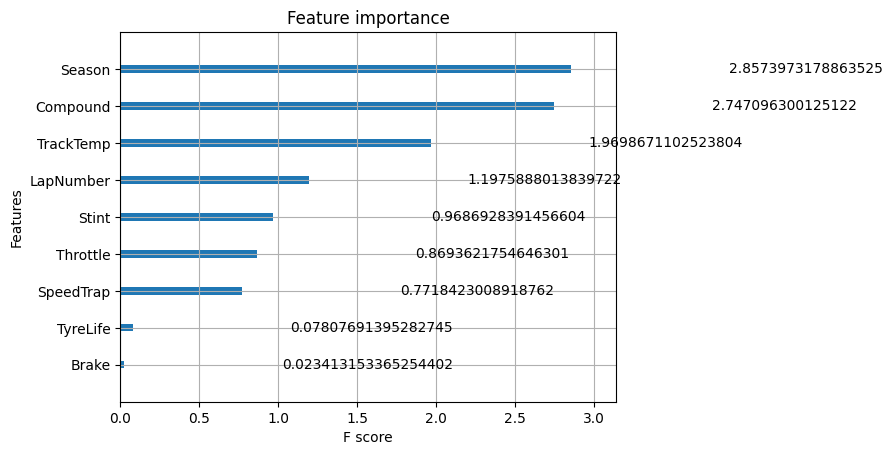

In [112]:
importance = best_model.get_booster().get_score(importance_type='gain')
xgb.plot_importance(best_model, importance_type='gain')
plt.show()

In [122]:
errors = []
scores = []
predicted_laps = []
df_2021 = filter_speed_trap(df.query("Season == 2021"), speed_trap)

for start_lap in range(0, len(df_2021) - laps_to_predict, laps_to_predict):
    real_time_model = best_model
    df_retrain = pd.concat([df_train, df_2021[:start_lap]], axis=0)
    df_test = df_2021[start_lap:start_lap + laps_to_predict]

    X_retrain = df_retrain[FEATURES]
    y_retrain = df_retrain[TARGET]

    real_time_model.fit(
        X_retrain, y_retrain, verbose=100, xgb_model=real_time_model
    )
    preds = real_time_model.predict(df_test[FEATURES])
    predicted_laps += preds.tolist()
    score_test = mean_squared_error(df_test['LapTime'], preds, squared=False)
    errors += (df_test['LapTime'] - preds).to_list()
    scores.append(score_test)

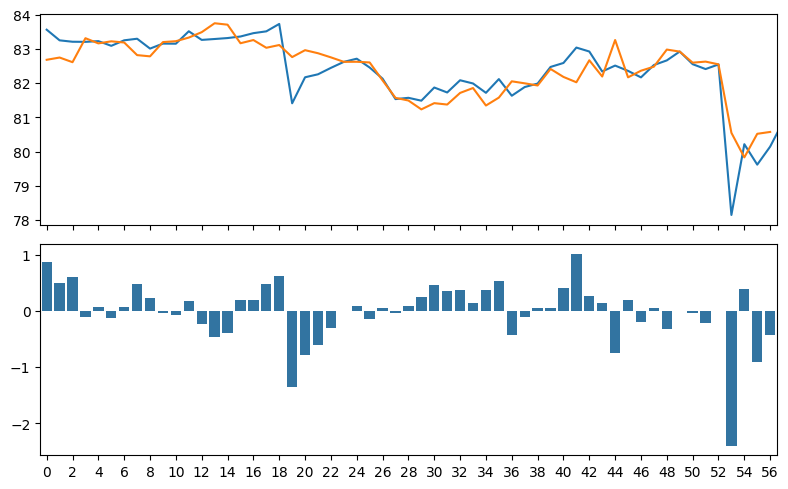

In [137]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 5), sharex=True)
sns.lineplot(df_2021['LapTime'].values, ax=ax1)
sns.lineplot(predicted_laps, ax=ax1)
sns.barplot(errors, ax=ax2)
locs, labels = plt.xticks()
plt.xticks(locs[::2], labels[::2])
plt.tight_layout()

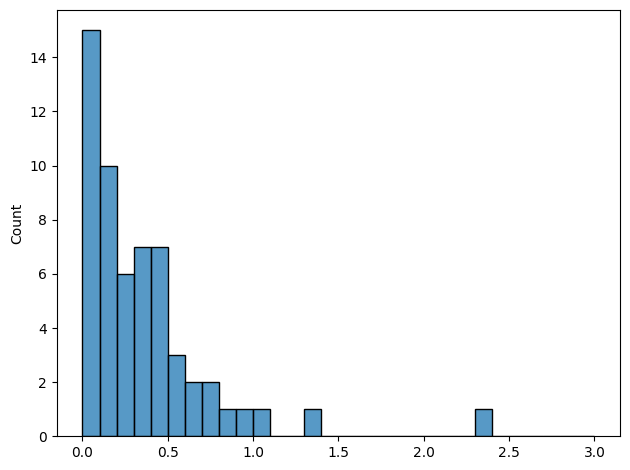

In [145]:
mae = np.abs(errors)
sns.histplot(mae, binwidth=0.1, binrange=(0,3))
plt.tight_layout()